# СБОРНЫЙ ПРОЕКТ 2

<div class="alert alert-info"> <b>ИССЛЕДОВАНИЕ ПОВЕДЕНИЯ ПОЛЬЗОВАТЕЛЕЙ МОБИЛЬНОГО ПРИЛОЖЕНИЯ</b></div>

# Описание проекта

Вы работаете в стартапе, который продаёт продукты питания. <br/>Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.<br/>
Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?<br/>
После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.
Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.<br/>
В случае общей аналитики и A/A/B-эксперимента работайте с одними и теми же данными. В реальных проектах всегда идут эксперименты. Аналитики исследуют качество работы приложения по общим данным, не учитывая принадлежность пользователей к экспериментам.

# Описание данных

Каждая запись в логе — это действие пользователя, или событие. <br>
EventName — название события;<br>
DeviceIDHash — уникальный идентификатор пользователя;<br>
EventTimestamp — время события;<br>
ExpId — номер эксперимента: <br>
246 и 247 — контрольные группы, а 248 — экспериментальная.

### Шаг 1. Изучение файла с данными и общей информации

In [1]:
import pandas as pd
import datetime as dt
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import math as mth
from scipy import stats as st
import scipy.stats as stats
from pandas.plotting import register_matplotlib_converters
#from multipy.fwer import sidak

In [2]:
logs = pd.read_csv('https://code.s3.yandex.net/datasets/logs_exp.csv', sep='\t')
display(logs.head(10))
logs.isin([np.int64(1), np.int64(2)])

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False
...,...,...,...,...
244121,False,False,False,False
244122,False,False,False,False
244123,False,False,False,False
244124,False,False,False,False


### Шаг 2. Подготовка данных

- Замените названия столбцов на удобные для вас;
- Проверьте пропуски и типы данных. Откорректируйте, если нужно;
- Добавьте столбец даты и времени, а также отдельный столбец дат;

#### Замена названий столбцов

In [3]:
#log.columns = logs.columns.str.lower()

# Заменяем названия столбцов
logs = logs.rename(columns={
    'EventName': 'events',
    'DeviceIDHash': 'device_id',
    'EventTimestamp': 'event_timestamp',
    'ExpId': 'exp_id'
})
display(logs.head())

,events,device_id,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


#### Проверка пропусков и типов данных

In [4]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   events           244126 non-null  object
 1   device_id        244126 non-null  int64 
 2   event_timestamp  244126 non-null  int64 
 3   exp_id           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


<b>Всего в датафрейме 244126 строк. Типы данных, кроме event_time, соответствуют данным.  </b>

In [5]:
logs.isna().sum()

events             0
device_id          0
event_timestamp    0
exp_id             0
dtype: int64

<b>Пропусков в строках не обнаружено. </b>

In [6]:
# Проверка дубликатов
# duplicateRows = logs[logs.duplicated()]
# print(duplicateRows)
# # Проверка по имени, платформе и году релиза одновременно.
# duplicateRows_two = logs[logs.duplicated(['event_name', 'device_id', 'event_time'])]
# display(duplicateRows_two)
# duplicateRows_two.count()

#### Добавление столбцов даты и времени и отдельно дат

In [7]:
# Создаем колонкb с датой-временем и с датой отдельно
logs['dt'] = pd.to_datetime(logs['event_timestamp'],   unit="s")
logs['date'] = pd.to_datetime(logs['dt']).dt.date
logs['date'] = pd.to_datetime(logs['date'])
display(logs.head())
display(logs.tail())

,events,device_id,event_timestamp,exp_id,dt,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


,events,device_id,event_timestamp,exp_id,dt,date
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07
244125,OffersScreenAppear,5746969938801999050,1565212517,246,2019-08-07 21:15:17,2019-08-07


In [8]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   events           244126 non-null  object        
 1   device_id        244126 non-null  int64         
 2   event_timestamp  244126 non-null  int64         
 3   exp_id           244126 non-null  int64         
 4   dt               244126 non-null  datetime64[ns]
 5   date             244126 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 11.2+ MB


Добавили две колонки с датами/временем и с датой отдельно как указано в задании

#### Проверка пересечения пользователей в группах

In [9]:
# Проверим отсутствие пересечения пользователей в группах 246/247

mask = logs.loc[logs["exp_id"]==246, "device_id"].isin(logs.loc[logs["exp_id"]==247, "device_id"])
print(mask.unique())
#res = df.drop(mask[mask].index)

[False]


In [10]:
# Проверим отсутствие пересечения пользователей в группах 246/248

mask = logs.loc[logs["exp_id"]==246, "device_id"].isin(logs.loc[logs["exp_id"]==248, "device_id"])
print(mask.unique())
#res = df.drop(mask[mask].index)

[False]


In [11]:
# Проверим отсутствие пересечения пользователей в группах 247/248

mask = logs.loc[logs["exp_id"]==247, "device_id"].isin(logs.loc[logs["exp_id"]==248, "device_id"])
print(mask.unique())
#res = df.drop(mask[mask].index)

[False]


### Шаг 3. Изучение и проверка данных

- Сколько всего событий в логе?
- Сколько всего пользователей в логе?
- Сколько в среднем событий приходится на пользователя?
- Данными за какой период вы располагаете? Найдите максимальную и минимальную дату. Изучите, как меняется количество данных: постройте столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?
- Много ли событий и пользователей вы потеряли, отбросив старые данные?
- Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.

#### Количество событий в логе

In [12]:
print(logs['events'].unique())
print('Количество событий в логе: ', logs['events'].nunique())

['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']
Количество событий в логе:  5


<b>В логе 5 событий:</b> <br/>1) MainScreenAppear, <br/>2) PaymentScreenSuccessful, <br/>3) CartScreenAppear, <br/>
4) OffersScreenAppear, <br/> 5) Tutorial. 

#### Количество пользователей в логе

In [13]:
# Количество пользователей в логе
n = len(pd.unique(logs['device_id']))
print("Количество пользователей в логе:", n)

Количество пользователей в логе: 7551


#### Среднее количество событий на пользователя

In [14]:
logs_outliers = logs.groupby('device_id').agg({'events':'count'})
print(logs_outliers.head(10))

                   events
device_id                
6888746892508752        1
6909561520679493        5
6922444491712477       47
7435777799948366        6
7702139951469979      137
8486814028069281       10
8740973466195562        9
9841258664663090       29
12692216027168046      10
15708180189885246     126


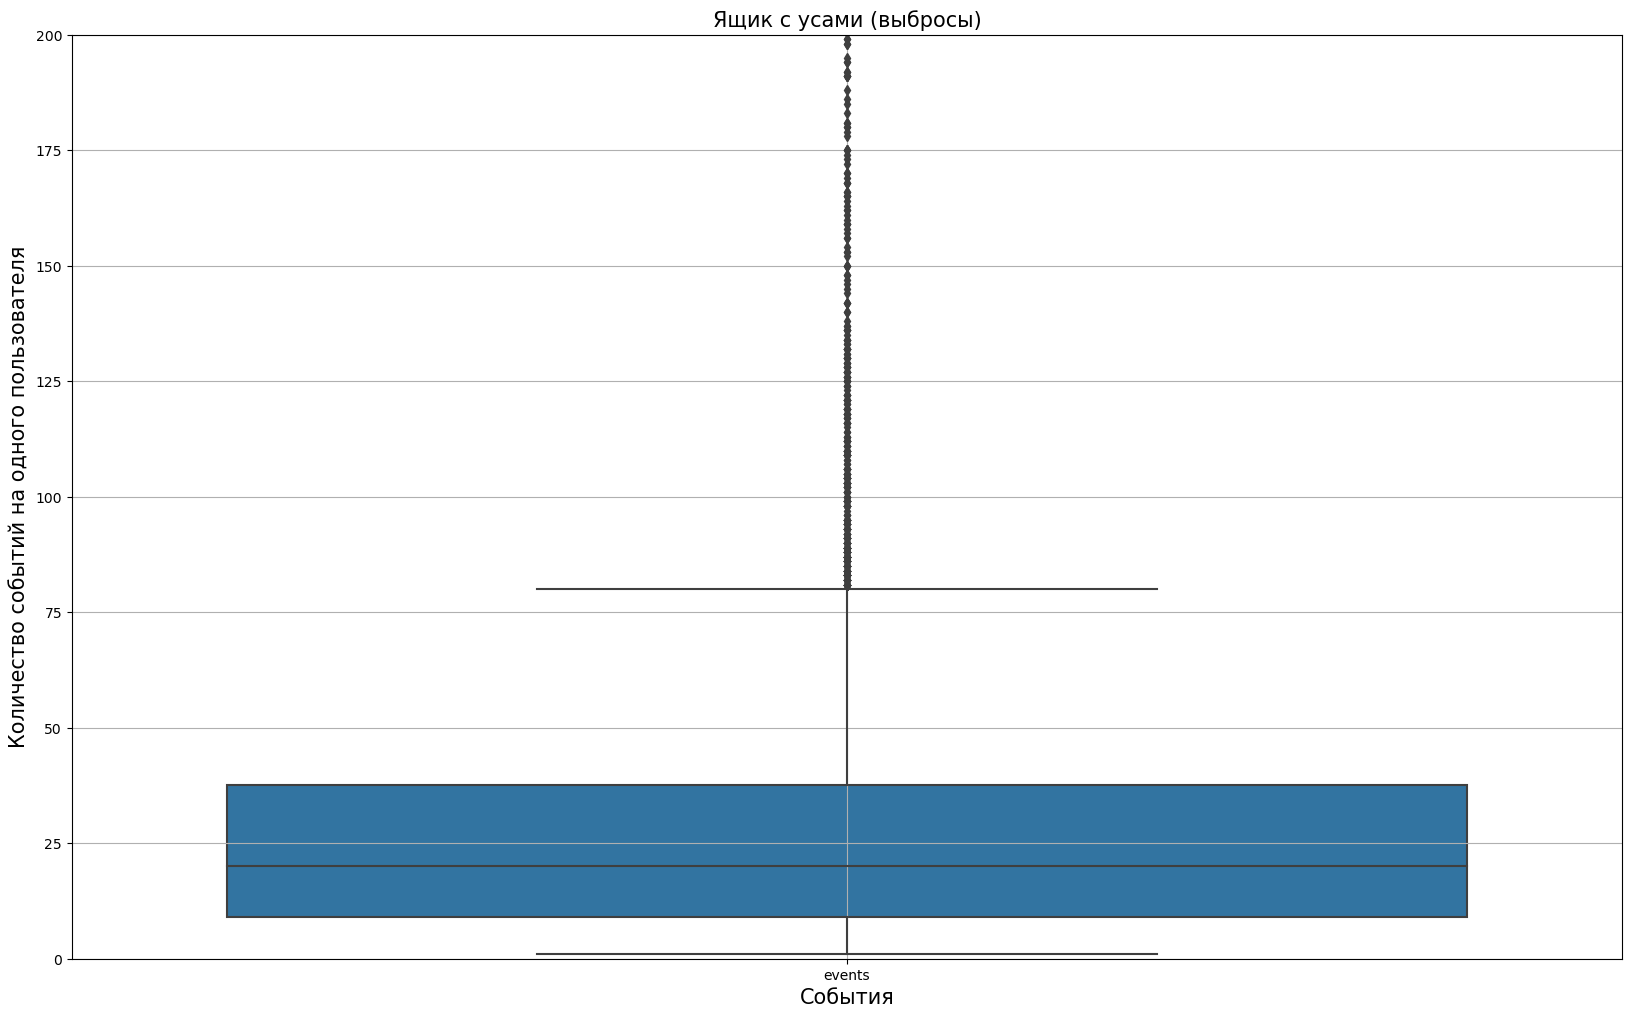

In [15]:
# Ящики с усами 
plt.figure(figsize=(20,12))
sns.boxplot(data=logs_outliers)
plt.title('Ящик с усами (выбросы)', fontsize=15)
plt.xlabel('События', fontsize=15)
plt.ylabel('Количество событий на одного пользователя',fontsize=15)
plt.grid()
plt.ylim(0, 200.0)
plt.show()

In [16]:
# total_number_of_events = logs['events'].count()
# total_number_of_users = logs['device_id'].nunique()
# avg_number_of_events = round(total_number_of_events/total_number_of_users, 0)
# print('В среднем', avg_number_of_events, 'события приходится на пользователя')

avg_number_of_events = logs_outliers['events'].median()
print('В среднем', avg_number_of_events, 'событий приходится на пользователя')

В среднем 20.0 событий приходится на пользователя


#### Анализ данных в разрезе периода. Даты, диаграммы, актуальность данных.

In [17]:
# минимальная и максимальная даты привлечения пользователей.
min_observation_date = logs.dt.min()
max_observation_date = logs.dt.max()

print(f'Минимальная дата привлечения пользователей', min_observation_date)
print(f'Максимальная дата привлечения пользователей', max_observation_date)

Минимальная дата привлечения пользователей 2019-07-25 04:43:36
Максимальная дата привлечения пользователей 2019-08-07 21:15:17


<b>Анализ ведется за период с 25 июля по 7 августа 2019 года.</b>

exp_id,246,247,248
date,,,
2019-07-25,4,1,4
2019-07-26,14,8,9
2019-07-27,24,23,8
2019-07-28,33,36,36
2019-07-29,55,58,71
2019-07-30,129,138,146
2019-07-31,620,664,747
2019-08-01,11581,12336,12312
2019-08-02,10960,11015,13631


<Figure size 1600x800 with 0 Axes>

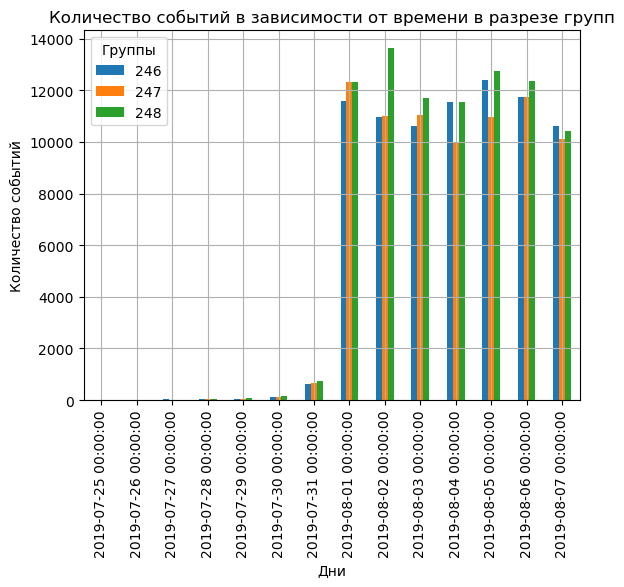

In [18]:
groups = logs.pivot_table(index = 'date', columns = 'exp_id', values = 'events', aggfunc = 'count')
display(groups)
plt.figure(figsize=(16, 8))
groups.plot(kind='bar')
plt.title('Количество событий в зависимости от времени в разрезе групп')
plt.xlabel('Дни')
plt.ylabel('Количество событий')
plt.legend(title='Группы')
plt.grid(True)
plt.xticks(rotation=90)
plt.show()

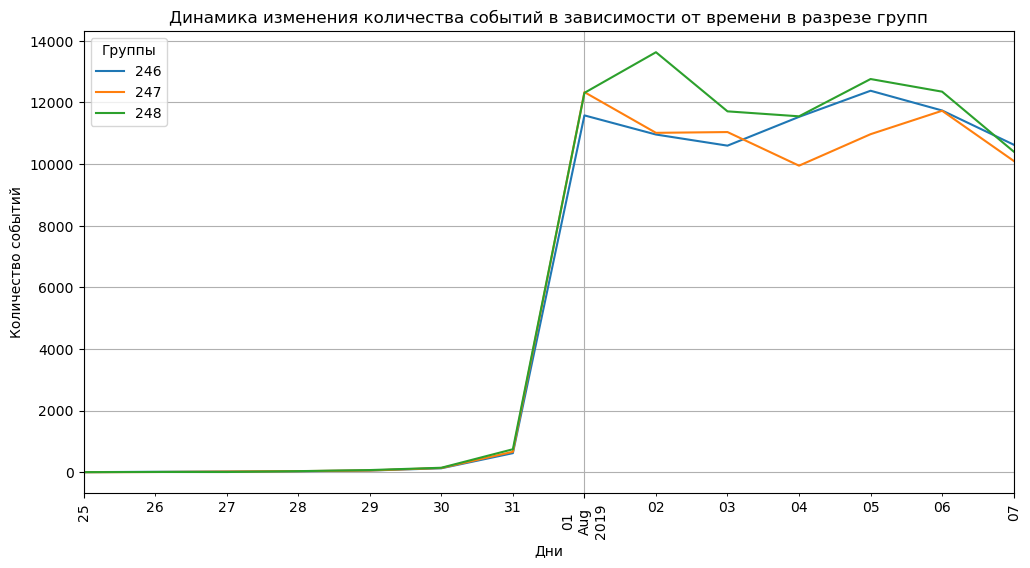

In [19]:
# График изменения количества событий в зависимости от времени в разрезе групп
plt.figure(figsize=(12, 6))
logs.groupby(['exp_id', 'date'])['events'].count().unstack('exp_id').plot(ax=plt.gca())
plt.title('Динамика изменения количества событий в зависимости от времени в разрезе групп')
plt.xlabel('Дни')
plt.ylabel('Количество событий')
plt.legend(title='Группы')
plt.grid(True)
plt.xticks(rotation=90)
plt.show()

In [20]:
logs.groupby('exp_id')['events'].agg('count')

exp_id
246    80304
247    78075
248    85747
Name: events, dtype: int64

<b>Графики показывают, что за весь период данные не одинаково полные.<br/>
С 01 августа идет резкий скачок вверх в 20 раз по показателю количества событий.<br/></b>


In [21]:
# Срез данных за период 01-07 авг
filtered_logs = logs.loc[(logs['date'] > '2019-07-31') & (logs['date'] < '2019-08-08')]
display(filtered_logs)

,events,device_id,event_timestamp,exp_id,dt,date
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


exp_id,246,247,248
date,,,
2019-08-01,11581,12336,12312
2019-08-02,10960,11015,13631
2019-08-03,10599,11040,11712
2019-08-04,11533,9949,11551
2019-08-05,12381,10971,12761
2019-08-06,11740,11731,12351
2019-08-07,10631,10105,10408


<Figure size 2000x1000 with 0 Axes>

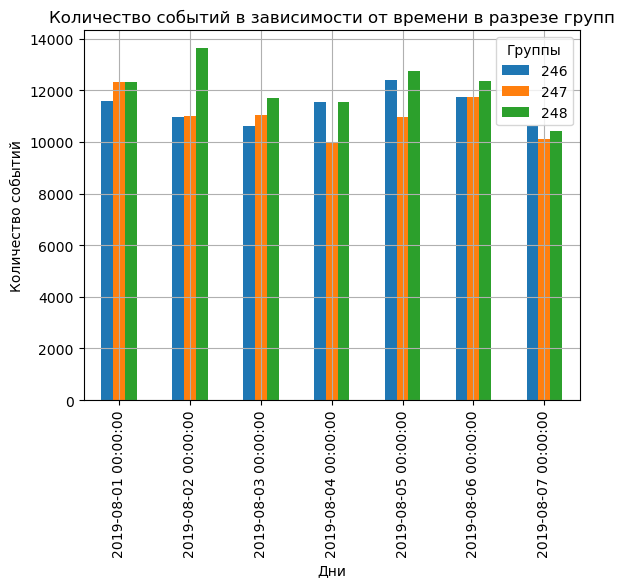

In [22]:
groups_two = filtered_logs.pivot_table(index = 'date', columns = 'exp_id', values = 'events', aggfunc = 'count')
display(groups_two)

plt.figure(figsize=(20, 10))
groups_two.plot(kind='bar')
plt.title('Количество событий в зависимости от времени в разрезе групп')
plt.xlabel('Дни')
plt.ylabel('Количество событий')
plt.legend(title='Группы')
plt.grid(True)
plt.xticks(rotation=90)
plt.show()

#### Разница в суммарном количестве событий до и после среза

In [23]:
# Количество событий в логе после среза
events_after_cutting = filtered_logs.groupby('exp_id').agg({'events':'count'})
display(events_after_cutting)

total_after =events_after_cutting['events'].sum()
print('Всего событий:', total_after)

# Количество пользователей в логе после среза
m = len(pd.unique(filtered_logs['device_id']))
print("Количество пользователей в логе после среза:", m)

,events
exp_id,
246,79425
247,77147
248,84726


Всего событий: 241298
Количество пользователей в логе после среза: 7534


In [24]:
# Количество событий в логе до среза
events_before_cutting = logs.groupby('exp_id').agg({'events':'count'})
display(events_before_cutting)

total_before = events_before_cutting['events'].sum()
print('Всего событий:', total_before)

# Количество пользователей в логе до среза
l = len(pd.unique(logs['device_id']))
print("Количество пользователей в логе до среза:", l)

,events
exp_id,
246,80304
247,78075
248,85747


Всего событий: 244126
Количество пользователей в логе до среза: 7551


In [25]:
# Расчёт разницы в суммарном количестве событий до и после среза:

diffrence_in_events_count = events_before_cutting['events'] - events_after_cutting['events']
print(diffrence_in_events_count)
print()
print('Разница в суммарном количестве событий до и после среза:', total_before - total_after)

exp_id
246     879
247     928
248    1021
Name: events, dtype: int64

Разница в суммарном количестве событий до и после среза: 2828


<b>Отбросив ранние данные, мы теперь имеем данные за период 01.08 - 07.08. <br>
Потеряли относительно немного пользователей: с 7551 уменьшилось до 7534 пользователей. <br>
Пользователи из всех трех экспериментальных групп есть в анализе после сброса.</b>

### Шаг 4. Изучение воронки событий

- Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.
- Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.
- Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.
- По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.
- На каком шаге теряете больше всего пользователей?
- Какая доля пользователей доходит от первого события до оплаты?

#### Сортировка событий по частоте

events
MainScreenAppear           117431
OffersScreenAppear          46350
CartScreenAppear            42365
PaymentScreenSuccessful     34113
Tutorial                     1039
Name: device_id, dtype: int64

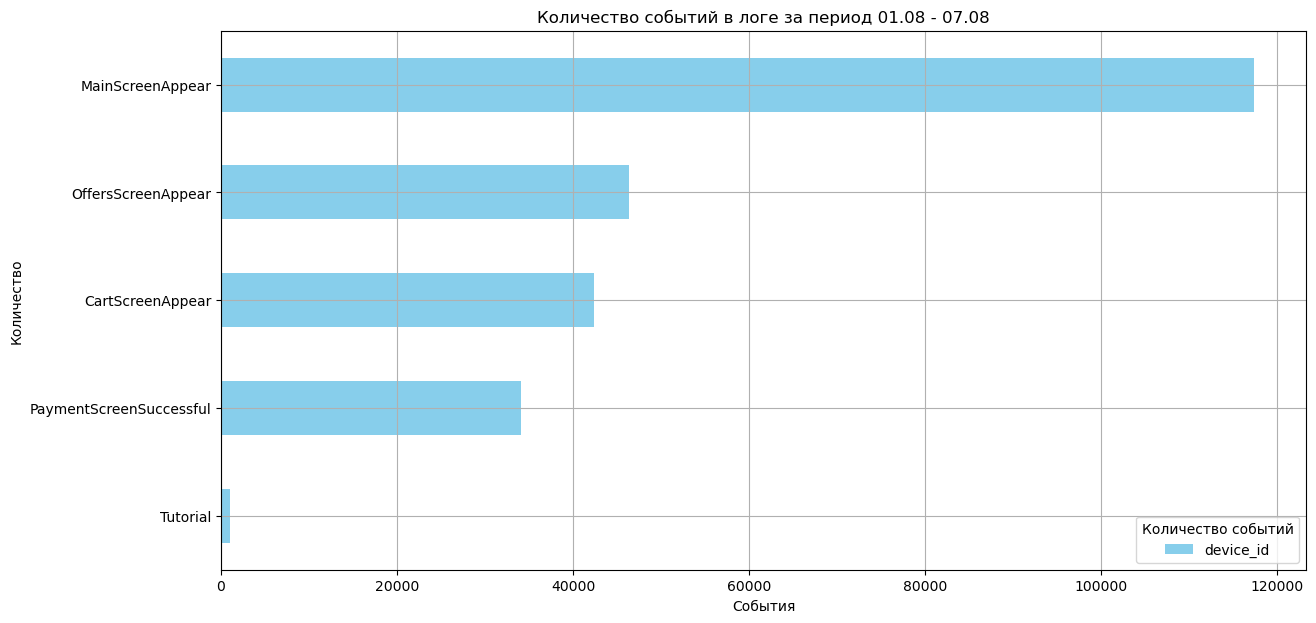

In [26]:
events_counts = filtered_logs.groupby('events')['device_id'].agg('count').sort_values(ascending=False)
display(events_counts)

plt.figure(figsize=(14, 7))
#events_counts.plot(kind='bar')
ax = events_counts.sort_values().plot(kind='barh', color='skyblue')
plt.title('Количество событий в логе за период 01.08 - 07.08')
plt.xlabel('События')
plt.ylabel('Количество')
plt.legend(title='Количество событий')
plt.grid(True)
#plt.xticks(rotation=90)
plt.show()

#### Подсчет пользователей

In [27]:
# Количество пользователей по каждому событию
users_count = filtered_logs.groupby('events').agg({'device_id': 'nunique'}).sort_values(by='device_id', ascending = False)
display(users_count)

,device_id
events,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539
Tutorial,840


In [28]:
# доля пользователей, которые хоть раз совершили событие

# first_real_event = users_count.iloc[1]
# total_users = (len(pd.unique(filtered_logs['device_id'])))

# share_of_users = round(first_real_event / total_users * 100).map("{:.1f}%".format)

# print('Доля пользователей, хоть раз совершавших событие ', share_of_users)

In [29]:
# доля пользователей, которые хоть раз совершили событие

users_count_two = logs['device_id'].nunique()
users_share_at_least_one_event = round((users_count/users_count_two)*100,2)
users_share_at_least_one_event.sort_values(by = 'device_id', ascending = False)

,device_id
events,
MainScreenAppear,98.25
OffersScreenAppear,60.83
CartScreenAppear,49.45
PaymentScreenSuccessful,46.87
Tutorial,11.12


#### Работа с событиями

<b>В каком порядке происходят события? </b><br>
- Открывается страница с инструкцией (Tutorial),
- Клиент открывает главную страницу (MainScreenAppear),
- Клиент заходит в страницу с каталогом продуктов питания (OffersScreenAppear),
- Клиент кладет выбранный товар в корзину (CartScreenAppear),
- Клиент оплачивает выбранные товары в корзине (PaymentScreenSuccessful)

Событие с прочтением инструкции не выстраивается в общую последовательность.<br>
Скорее всего, причина в том, что обычно клиенты обходят этот этап, так как дальнейшие шаги понятны большинству пользователей.<br>
Данное событие (Tutorial) не будем учитывать при расчете воронки.

#### Воронка событий

In [30]:
a = users_count.iloc[0] # Клиент открывает главную страницу
b = users_count.iloc[1] # Клиент заходит в страницу с каталогом продуктов питания
c = users_count.iloc[2] # Клиент кладет выбранный товар в корзину
d = users_count.iloc[3] # Клиент оплачивает выбранные товары в корзине

print('Доля пользователей, перешедших на страницу с каталогом продукции ', round(b/a*100,1).map("{:.1f}%".format))
print('Доля пользователей, положивших товар(ы) в корзину ', round(c/b*100,1).map("{:.1f}%".format))
print('Доля пользователей, оплативших товар ', round(d/c*100,1).map("{:.1f}%".format))

Доля пользователей, перешедших на страницу с каталогом продукции  device_id    61.9%
dtype: object
Доля пользователей, положивших товар(ы) в корзину  device_id    81.3%
dtype: object
Доля пользователей, оплативших товар  device_id    94.8%
dtype: object


<b>Доля пользователей, перешедших на страницу с каталогом продукции после главной страницы = 61.9%<br>
Доля пользователей, положивших товар(ы) в корзину после просмотра каталогов = 81.3%<br>
Доля пользователей, оплативших товара(ов), положенных в корзину = 94.8%</b>

На этапе перехода на страницу с каталогом товаров теряется больше всего клиентов - почти 40%.<br>
Также, поместив товары в корзину, 5% клиентов не оплатили за них. 

In [31]:
print('Доля пользователей, дошедших от первого события до оплаты ', round(d/a*100,1).map("{:.1f}%".format));

Доля пользователей, дошедших от первого события до оплаты  device_id    47.7%
dtype: object


<b>Всего 47.7% пользователей дошли от захода на главную страницу до покупки товаров.</b>

### Шаг 5. Изучение результатов эксперимента

- Сколько пользователей в каждой экспериментальной группе?
- Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.
- Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?
- Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?
- Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 в 10% случаев можно ошибочно отклонить нулевую гипотезу при условии, что она верна. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

#### Количество пользователей в группах

In [32]:
# Категоризация по эксп. группам
def users_category(exp):
    if exp == 246:
        return 1
    if exp == 247:
        return 2
    else:
        return 3

filtered_logs = filtered_logs.copy()
filtered_logs['exp_group_category'] = filtered_logs['exp_id'].apply(users_category)

filtered_logs.head(10)

,events,device_id,event_timestamp,exp_id,dt,date,exp_group_category
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01,1
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01,1
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01,1
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01,1
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01,2
2833,MainScreenAppear,4899590676214355127,1564618215,247,2019-08-01 00:10:15,2019-08-01,2
2834,OffersScreenAppear,3737462046622621720,1564618226,246,2019-08-01 00:10:26,2019-08-01,1
2835,MainScreenAppear,3737462046622621720,1564618247,246,2019-08-01 00:10:47,2019-08-01,1
2836,MainScreenAppear,3737462046622621720,1564618270,246,2019-08-01 00:11:10,2019-08-01,1
2837,MainScreenAppear,3737462046622621720,1564618280,246,2019-08-01 00:11:20,2019-08-01,1


In [33]:
# Количество пользователей в каждой экспериментальной группе
users_count_in_groups = filtered_logs.groupby('exp_id')['device_id'].agg('nunique')
print(users_count_in_groups)



exp_id
246    2484
247    2513
248    2537
Name: device_id, dtype: int64


<b>Количество пользователей в экспериментальных группах:</b><br>
- В контрольной группе номер 246: 2484 чел.
- В контрольной группе номер 247: 2513 чел.
- В экспериментальной группе номер 248: 2537 чел.

#### Контрольные группы для А/А-эксперимента

In [34]:
#создаем таблицу с данными только для '246'
group_246_only = filtered_logs.loc[filtered_logs['exp_id'] == 246]
display(group_246_only)

,events,device_id,event_timestamp,exp_id,dt,date,exp_group_category
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01,1
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01,1
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01,1
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01,1
2834,OffersScreenAppear,3737462046622621720,1564618226,246,2019-08-01 00:10:26,2019-08-01,1
...,...,...,...,...,...,...,...
244120,MainScreenAppear,5746969938801999050,1565212331,246,2019-08-07 21:12:11,2019-08-07,1
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07,1
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07,1
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07,1


In [35]:
#создаем таблицу с данными только для '247'
group_247_only = filtered_logs.loc[filtered_logs['exp_id'] == 247]
display(group_247_only)

,events,device_id,event_timestamp,exp_id,dt,date,exp_group_category
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01,2
2833,MainScreenAppear,4899590676214355127,1564618215,247,2019-08-01 00:10:15,2019-08-01,2
2838,MainScreenAppear,4899590676214355127,1564618288,247,2019-08-01 00:11:28,2019-08-01,2
2839,OffersScreenAppear,4899590676214355127,1564618290,247,2019-08-01 00:11:30,2019-08-01,2
2843,OffersScreenAppear,4899590676214355127,1564618356,247,2019-08-01 00:12:36,2019-08-01,2
...,...,...,...,...,...,...,...
244088,MainScreenAppear,2300292234025330845,1565211937,247,2019-08-07 21:05:37,2019-08-07,2
244089,OffersScreenAppear,2300292234025330845,1565211943,247,2019-08-07 21:05:43,2019-08-07,2
244090,OffersScreenAppear,2300292234025330845,1565211954,247,2019-08-07 21:05:54,2019-08-07,2
244091,MainScreenAppear,2300292234025330845,1565211957,247,2019-08-07 21:05:57,2019-08-07,2


events
MainScreenAppear           37708
OffersScreenAppear         14773
CartScreenAppear           14711
PaymentScreenSuccessful    11910
Tutorial                     323
Name: exp_id, dtype: int64

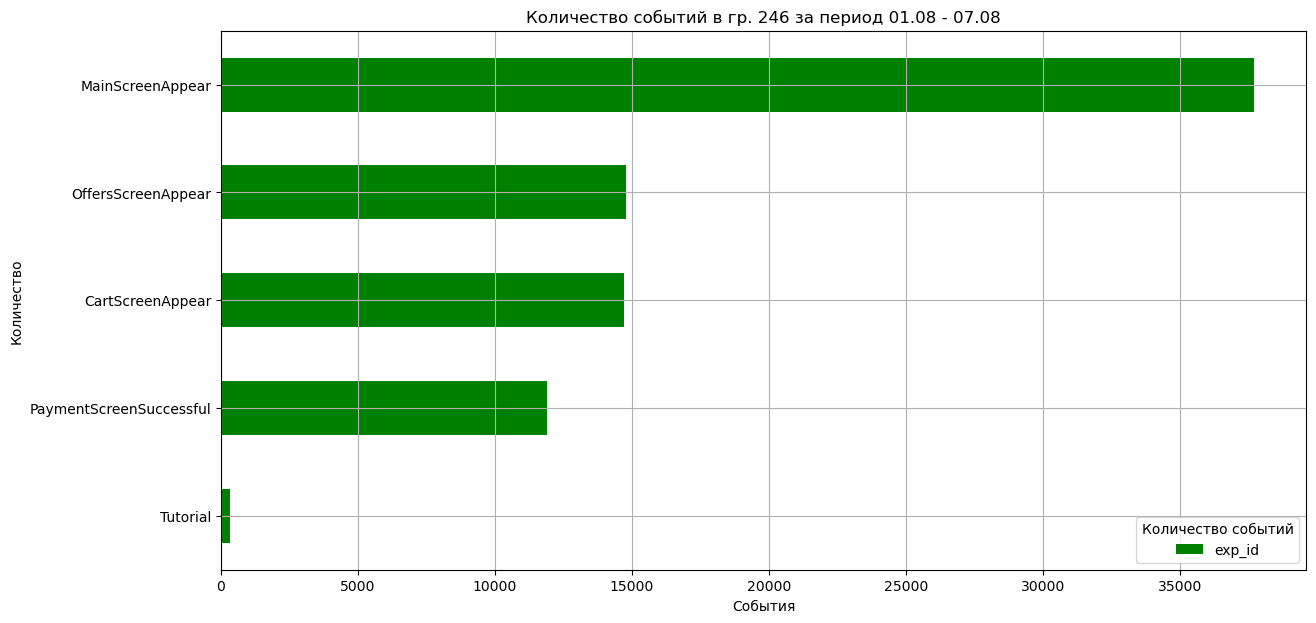

In [36]:
# Воронка для группы 246

events_counts_for_246 = group_246_only.groupby('events')['exp_id'].agg('count').sort_values(ascending=False)
display(events_counts_for_246)

plt.figure(figsize=(14, 7))
#events_counts.plot(kind='bar')
ax = events_counts_for_246.sort_values().plot(kind='barh', color='green')
plt.title('Количество событий в гр. 246 за период 01.08 - 07.08')
plt.xlabel('События')
plt.ylabel('Количество')
plt.legend(title='Количество событий')
plt.grid(True)
#plt.xticks(rotation=90)
plt.show()

events
MainScreenAppear           39123
OffersScreenAppear         15182
CartScreenAppear           12456
PaymentScreenSuccessful    10043
Tutorial                     343
Name: exp_id, dtype: int64

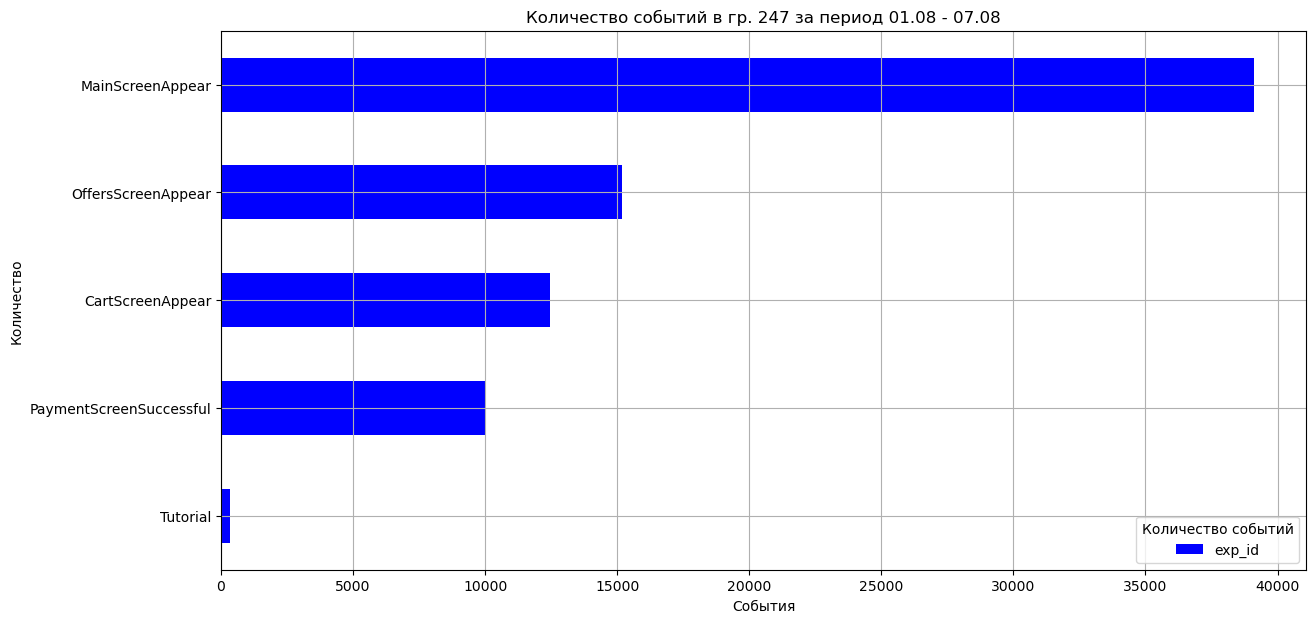

In [37]:
# Воронка для группы 247

events_counts_for_247 = group_247_only.groupby('events')['exp_id'].agg('count').sort_values(ascending=False)
display(events_counts_for_247)

plt.figure(figsize=(14, 7))
#events_counts.plot(kind='bar')
ax = events_counts_for_247.sort_values().plot(kind='barh', color='blue')
plt.title('Количество событий в гр. 247 за период 01.08 - 07.08')
plt.xlabel('События')
plt.ylabel('Количество')
plt.legend(title='Количество событий')
plt.grid(True)
#plt.xticks(rotation=90)
plt.show()

In [38]:
# Таблица только с группами 246 и 247
group_246_247 = filtered_logs.loc[(filtered_logs['exp_id'] == 246) | (filtered_logs['exp_id'] == 247)]
display(group_246_247)

,events,device_id,event_timestamp,exp_id,dt,date,exp_group_category
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01,1
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01,1
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01,1
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01,1
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01,2
...,...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07,2
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07,1
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07,1
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07,1


<Figure size 2000x1000 with 0 Axes>

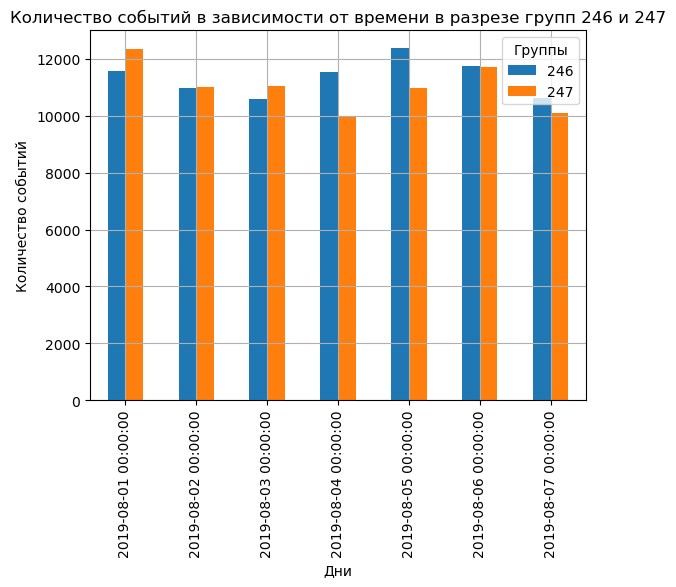

In [39]:
# Сравнительный график количества пользователей двух групп в разрезе времени
compare_246_247 = group_246_247.pivot_table(index = 'date', columns = 'exp_id', values = 'events', aggfunc = 'count')
#display(groups)

plt.figure(figsize=(20, 10))
compare_246_247.plot(kind='bar')
plt.title('Количество событий в зависимости от времени в разрезе групп 246 и 247')
plt.xlabel('Дни')
plt.ylabel('Количество событий')
plt.legend(title='Группы')
plt.grid(True)
plt.xticks(rotation=90)
plt.show()

In [40]:
# Доля пользователей, дошедших от первого события до оплаты в группе 246

users_count_246 = group_246_only.groupby('events').agg({'device_id': 'nunique'}).sort_values(by='device_id', ascending = False)
display(users_count_246)

a_246 = users_count_246.iloc[0] # Клиент открывает главную страницу
b_246 = users_count_246.iloc[1] # Клиент заходит в страницу с каталогом продуктов питания
c_246 = users_count_246.iloc[2] # Клиент кладет выбранный товар в корзину
d_246 = users_count_246.iloc[3] # Клиент оплачивает выбранные товары в корзине

print('Доля пользователей гр. 246, дошедших от первого события до оплаты ', round(d_246/a_246*100,1).map("{:.1f}%".format));

,device_id
events,
MainScreenAppear,2450
OffersScreenAppear,1542
CartScreenAppear,1266
PaymentScreenSuccessful,1200
Tutorial,278


Доля пользователей гр. 246, дошедших от первого события до оплаты  device_id    49.0%
dtype: object


In [41]:
# Доля пользователей, дошедших от первого события до оплаты в группе 247

users_count_247 = group_247_only.groupby('events').agg({'device_id': 'nunique'}).sort_values(by='device_id', ascending = False)
display(users_count_247)

a_247 = users_count_247.iloc[0] # Клиент открывает главную страницу
b_247 = users_count_247.iloc[1] # Клиент заходит в страницу с каталогом продуктов питания
c_247 = users_count_247.iloc[2] # Клиент кладет выбранный товар в корзину
d_247 = users_count_247.iloc[3] # Клиент оплачивает выбранные товары в корзине

print('Доля пользователей гр. 247, дошедших от первого события до оплаты ', round(d_247/a_247*100,1).map("{:.1f}%".format));

,device_id
events,
MainScreenAppear,2476
OffersScreenAppear,1520
CartScreenAppear,1238
PaymentScreenSuccessful,1158
Tutorial,283


Доля пользователей гр. 247, дошедших от первого события до оплаты  device_id    46.8%
dtype: object


<b>Промежуточные выводы:</b><br>
<p></p>
Количество действий по каждому событию по группе 246 сложились следующим образом:<br>
- Открытие главной страницы         37708 раз<br>
- Открытие страницы с предложениями 14773 раз<br>
- Перемещиение товара(ов) в корзину 14711 раз<br>
- Оплата товара(ов)                 11910 раз<br>
<p></p>
Количество действий по каждому событию по группе 247:<br>
- Открытие главной страницы         39123 раз<br>
- Открытие страницы с предложениями 15182 раз<br>
- Перемещиение товара(ов) в корзину 12456 раз<br>
- Оплата товара(ов)                 10043 раз<br>
<p></p>

По воронкам продаж картина следующая: <br>
- Доля пользователей гр. 246, дошедших от первого события до оплаты  = 49.0%, <br>
- Доля пользователей гр. 247, дошедших от первого события до оплаты  = 46.8%.
<p></p>

2450 пользователей гр. 246 открыли главную страницу, из которых 1200 совершили покупку.<br>
В группе 247 главную страницу открыли 2476 пользователей, но покупку совершили 1158 чел. 
<p></p>

<b>По предварительным статистическим показателеям разница между группами 246 и 247 существует.</b>


#### Анализ популярного события. Сравнение гипотез по группам

In [42]:
# функция для анализа событий

def event_analysis(analyzed_event, group_number):
    analyzed_group = filtered_logs.loc[filtered_logs['exp_id'] == group_number]
    user_counts = analyzed_group.groupby('events').agg({'device_id': 'nunique'}).sort_values(by='device_id', ascending = False)
#     display(user_counts)
    
    basic_event = user_counts.iloc[0] 
    
    if analyzed_event == 'OffersScreenAppear':
        b = user_counts.iloc[1] 
        print('Доля пользователей гр.', {group_number}\
              , 'дошедших от первого события до', {analyzed_event}\
              , round(b/basic_event*100,1).map("{:.1f}%".format))
    if analyzed_event == 'CartScreenAppear':
        c = user_counts.iloc[2] 
        print('Доля пользователей гр.', {group_number}\
              , 'дошедших от первого события до', {analyzed_event}\
              , round(c/basic_event*100,1).map("{:.1f}%".format))
    if analyzed_event == 'PaymentScreenSuccessful':
        d = user_counts.iloc[3] 
        print('Доля пользователей гр.', {group_number}\
              , 'дошедших от первого события до', {analyzed_event}\
              , round(d/basic_event*100,1).map("{:.1f}%".format))

    return analyzed_group

In [43]:
event_2 = 'OffersScreenAppear'# Клиент заходит в страницу с каталогом продуктов питания
event_3 = 'CartScreenAppear' # Клиент кладет выбранный товар в корзину
event_4 = 'PaymentScreenSuccessful' # Клиент оплачивает выбранные товары в корзине

In [44]:
# Формула для расчета количества пользователей в каждом событии по группам и доли пользователей в каждом событий
# В качестве "популярного события" выберем Оплату выбранного товара
ev_4_246 = event_analysis(event_4, 246);

Доля пользователей гр. {246} дошедших от первого события до {'PaymentScreenSuccessful'} device_id    49.0%
dtype: object


In [45]:
# "популярное событие" - Оплата выбранного товара - для гр. 247
ev_4_247 = event_analysis(event_4, 247)


Доля пользователей гр. {247} дошедших от первого события до {'PaymentScreenSuccessful'} device_id    46.8%
dtype: object


В группе 246 на 2.2% больше пользователей совершило покупку. По количеству покупателей тоже превышает группу 247.

<b>
Нулевая гипотеза (Н0) - в сравниваемых группах нет разницы между долями пользователей совершивших событие.<br><p></p>
Альтернативная гипотеза (Н1) - в группах есть разница между долями пользователей совершивших событие.</b>

In [46]:
# alpha = 0.05

# results = st.ttest_ind(users_count_246['device_id'], users_count_247['device_id'], alternative='greater')

# print(f'p-value: {results.pvalue}')

# if results.pvalue < alpha:
#     print('Вывод: Отвергаем нулевую гипотезу')
# else:
#     print('Вывод: Нет оснований отвергнуть нулевую гипотезу')

In [47]:
# переделаем датафрейм events_counts
events_counts = filtered_logs.groupby('events')['device_id'].agg(['count', 'nunique'])\
                            .reset_index()
events_counts.columns =['events', 'events_count', 'users_count']
print(events_counts)

                    events  events_count  users_count
0         CartScreenAppear         42365         3734
1         MainScreenAppear        117431         7419
2       OffersScreenAppear         46350         4593
3  PaymentScreenSuccessful         34113         3539
4                 Tutorial          1039          840


In [48]:
# упорядочинвание событий
groups = [246, 247, 248]
events_and_groups = {}
order = (events_counts[events_counts['events'] != 'Tutorial']
         .sort_values('events_count', ascending=False)['events']
         .reset_index(drop=True))

for group in groups:
    events_and_groups[group] =[]
    for event in order:
        events_and_groups[group]\
        .append(filtered_logs[(filtered_logs['exp_id'] == group) \
                                               & (filtered_logs['events'] == event)]['device_id'].nunique())
print(order)

0           MainScreenAppear
1         OffersScreenAppear
2           CartScreenAppear
3    PaymentScreenSuccessful
Name: events, dtype: object


In [49]:
# функция для проверки гипотезы о равенстве пропорций заказов, Z-value
# количество пользователей в группах        
users_count = {'all': filtered_logs['device_id'].nunique(), 
           246: filtered_logs[filtered_logs['exp_id']==246]['device_id'].nunique(),
           247: filtered_logs[filtered_logs['exp_id']==247]['device_id'].nunique(),
           248: filtered_logs[filtered_logs['exp_id']==248]['device_id'].nunique(),
           'groups_246_247': filtered_logs[(filtered_logs['exp_id']==246) \
                                    | (filtered_logs['exp_id']==247)]['device_id'].nunique()}

events_and_groups = pd.DataFrame(events_and_groups)
events_and_groups['groups_246_247'] = events_and_groups[246] + events_and_groups[247]
events_and_groups['events'] = order

def z_score_compare(group_1, group_2, alpha):
    for i in events_and_groups.index:
        alpha = alpha
        p1 = events_and_groups[group_1][i] / users_count[group_1] # пропорция успехов в I группе:
        p2 = events_and_groups[group_2][i] / users_count[group_2] # пропорция успехов во II группе:
        p_combined = ((events_and_groups[group_1][i] + events_and_groups[group_2][i]) / 
                      (users_count[group_1] + users_count[group_2])) # пропорция успехов в объединенной контрольной группе:
        difference = p1 - p2 # разница пропорция в группах
        
        # Z-статистика
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * 
                                        (1/users_count[group_1] + 1/users_count[group_2]))
        # стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1) 
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print('{} p-значение: {}'.format(events_and_groups['events'][i], p_value))
        if (p_value < alpha):
            print("Отвергаем Нулевую гипотезу: между долями есть разница")
        else:
            print("Не отвергаем Нулевую гипотезу: нет оснований считать доли разными")
        print('')

In [50]:
print('Сравнение долей между группами 246 и 247:')
print()
z_score_compare(246,247,0.05)

Сравнение долей между группами 246 и 247:

MainScreenAppear p-значение: 0.7570597232046099
Не отвергаем Нулевую гипотезу: нет оснований считать доли разными

OffersScreenAppear p-значение: 0.2480954578522181
Не отвергаем Нулевую гипотезу: нет оснований считать доли разными

CartScreenAppear p-значение: 0.22883372237997213
Не отвергаем Нулевую гипотезу: нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.11456679313141849
Не отвергаем Нулевую гипотезу: нет оснований считать доли разными



Я бы предположил, что разбиение пользователей на две контрольные группы работает не совсем корректно.

#### Анализ группы с изменённым шрифтом

In [51]:
print('Сравнение долей между контрольной группой 246 и и экспериментальной группой 248 (с измененным шрифтом):')
print()
z_score_compare(246,248,0.05)

Сравнение долей между контрольной группой 246 и и экспериментальной группой 248 (с измененным шрифтом):

MainScreenAppear p-значение: 0.2949721933554552
Не отвергаем Нулевую гипотезу: нет оснований считать доли разными

OffersScreenAppear p-значение: 0.20836205402738917
Не отвергаем Нулевую гипотезу: нет оснований считать доли разными

CartScreenAppear p-значение: 0.07842923237520116
Не отвергаем Нулевую гипотезу: нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.2122553275697796
Не отвергаем Нулевую гипотезу: нет оснований считать доли разными



In [52]:
print('Сравнение долей между контрольной группой 247 и и экспериментальной группой 248 (с измененным шрифтом):')
print()
z_score_compare(247,248,0.05)

Сравнение долей между контрольной группой 247 и и экспериментальной группой 248 (с измененным шрифтом):

MainScreenAppear p-значение: 0.4587053616621515
Не отвергаем Нулевую гипотезу: нет оснований считать доли разными

OffersScreenAppear p-значение: 0.9197817830592261
Не отвергаем Нулевую гипотезу: нет оснований считать доли разными

CartScreenAppear p-значение: 0.5786197879539783
Не отвергаем Нулевую гипотезу: нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.7373415053803964
Не отвергаем Нулевую гипотезу: нет оснований считать доли разными



In [53]:
print('Сравнение долей между объединенной контрольной группой 246/247 и и экспериментальной группой 248 (с измененным шрифтом):')
print()
z_score_compare('groups_246_247',248,0.05)

Сравнение долей между объединенной контрольной группой 246/247 и и экспериментальной группой 248 (с измененным шрифтом):

MainScreenAppear p-значение: 0.29424526837179577
Не отвергаем Нулевую гипотезу: нет оснований считать доли разными

OffersScreenAppear p-значение: 0.43425549655188256
Не отвергаем Нулевую гипотезу: нет оснований считать доли разными

CartScreenAppear p-значение: 0.18175875284404386
Не отвергаем Нулевую гипотезу: нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.6004294282308704
Не отвергаем Нулевую гипотезу: нет оснований считать доли разными



#### Поправка на множественную проверку гипотез. Метод Шидака

<div class="alert alert-info"> <b>Комментарий студента в2:</b> <p></p> 
    Всего было проведено 16 проверок гипотез по 4 датасетам и 4 событиям со статиситичекой значимостью 0.05. </div>

In [54]:
#Анализ с использованием поправки на множественную проверку гипотез

sample_A = events_and_groups[246]
sample_B = events_and_groups[247]
sample_C = events_and_groups[248]
sample_D = events_and_groups['groups_246_247']

alpha = 0.05  # критический уровень статистической значимости

results_AB = st.ttest_ind(sample_A, sample_B)

results_BC = st.ttest_ind(sample_B, sample_C)

results_AC = st.ttest_ind(sample_A, sample_C)

results_DC = st.ttest_ind(sample_D, sample_C)

sidak_alpha = 1 - np.power((1 - alpha), 1/16) # произведено 16 сравнений

print('p-значение для сравнения групп А и B: ', results_AB.pvalue)
print('p-значение для сравнения групп B и C: ', results_BC.pvalue)
print('p-значение для сравнения групп А и C: ', results_AC.pvalue)
print('p-значение для сравнения групп D и C: ', results_DC.pvalue)

if results_AB.pvalue < sidak_alpha:
    print('Отвергаем нулевую гипотезу для сравнения групп А и B')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп А и B'
    )

if results_BC.pvalue < sidak_alpha:
    print('Отвергаем нулевую гипотезу для сравнения групп B и C')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп B и C'
    )

if results_AC.pvalue < sidak_alpha:
    print('Отвергаем нулевую гипотезу для сравнения групп А и C')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп А и C'
    )

if results_DC.pvalue < sidak_alpha:
    print('Отвергаем нулевую гипотезу для сравнения групп D и C')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп D и C'
    )


p-значение для сравнения групп А и B:  0.9697938310450083
p-значение для сравнения групп B и C:  0.9808472648044346
p-значение для сравнения групп А и C:  0.9895062693431196
p-значение для сравнения групп D и C:  0.05243191641862667
Не получилось отвергнуть нулевую гипотезу для сравнения групп А и B
Не получилось отвергнуть нулевую гипотезу для сравнения групп B и C
Не получилось отвергнуть нулевую гипотезу для сравнения групп А и C
Не получилось отвергнуть нулевую гипотезу для сравнения групп D и C


<div class="alert alert-info"> <b>Комментарий студента в2:</b> <p></p> 
    Анализ с использованием поправки на множественную проверку гипотез методом Шидака также показало отсутствие значимой разнциы между долями пользователей групп, совершивших события.</div>

#### Уровень значимости 0.1

In [55]:
print('Сравнение долей при уровне значимости 0.1 в группах 246 и 247:')
print()
z_score_compare(246,247,0.1)

Сравнение долей при уровне значимости 0.1 в группах 246 и 247:

MainScreenAppear p-значение: 0.7570597232046099
Не отвергаем Нулевую гипотезу: нет оснований считать доли разными

OffersScreenAppear p-значение: 0.2480954578522181
Не отвергаем Нулевую гипотезу: нет оснований считать доли разными

CartScreenAppear p-значение: 0.22883372237997213
Не отвергаем Нулевую гипотезу: нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.11456679313141849
Не отвергаем Нулевую гипотезу: нет оснований считать доли разными



In [56]:
print('Сравнение долей при уровне значимости 0.1  в группах 246 и 248:')
print()
z_score_compare(246,248,0.1)

Сравнение долей при уровне значимости 0.1  в группах 246 и 248:

MainScreenAppear p-значение: 0.2949721933554552
Не отвергаем Нулевую гипотезу: нет оснований считать доли разными

OffersScreenAppear p-значение: 0.20836205402738917
Не отвергаем Нулевую гипотезу: нет оснований считать доли разными

CartScreenAppear p-значение: 0.07842923237520116
Отвергаем Нулевую гипотезу: между долями есть разница

PaymentScreenSuccessful p-значение: 0.2122553275697796
Не отвергаем Нулевую гипотезу: нет оснований считать доли разными



In [57]:
print('Сравнение долей при уровне значимости 0.1  в группах 247 и 248:')
print()
z_score_compare(247,248,0.1)

Сравнение долей при уровне значимости 0.1  в группах 247 и 248:

MainScreenAppear p-значение: 0.4587053616621515
Не отвергаем Нулевую гипотезу: нет оснований считать доли разными

OffersScreenAppear p-значение: 0.9197817830592261
Не отвергаем Нулевую гипотезу: нет оснований считать доли разными

CartScreenAppear p-значение: 0.5786197879539783
Не отвергаем Нулевую гипотезу: нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.7373415053803964
Не отвергаем Нулевую гипотезу: нет оснований считать доли разными



In [58]:
print('Сравнение долей при уровне значимости 0.1 в группах (246 + 247) и 248:')
print()
z_score_compare('groups_246_247',248,0.1)

Сравнение долей при уровне значимости 0.1 в группах (246 + 247) и 248:

MainScreenAppear p-значение: 0.29424526837179577
Не отвергаем Нулевую гипотезу: нет оснований считать доли разными

OffersScreenAppear p-значение: 0.43425549655188256
Не отвергаем Нулевую гипотезу: нет оснований считать доли разными

CartScreenAppear p-значение: 0.18175875284404386
Не отвергаем Нулевую гипотезу: нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.6004294282308704
Не отвергаем Нулевую гипотезу: нет оснований считать доли разными



#### Сравнение долей пользователей в событиях

In [59]:
#создаем таблицу с данными только для '248'
group_248_only = filtered_logs.loc[filtered_logs['exp_id'] == 248]
display(group_248_only)

,events,device_id,event_timestamp,exp_id,dt,date,exp_group_category
2844,MainScreenAppear,4613461174774205834,1564618471,248,2019-08-01 00:14:31,2019-08-01,3
2845,MainScreenAppear,4613461174774205834,1564618474,248,2019-08-01 00:14:34,2019-08-01,3
2846,CartScreenAppear,4613461174774205834,1564618474,248,2019-08-01 00:14:34,2019-08-01,3
2847,PaymentScreenSuccessful,4613461174774205834,1564618483,248,2019-08-01 00:14:43,2019-08-01,3
2848,OffersScreenAppear,4613461174774205834,1564618491,248,2019-08-01 00:14:51,2019-08-01,3
...,...,...,...,...,...,...,...
244082,MainScreenAppear,8249271441488197538,1565211813,248,2019-08-07 21:03:33,2019-08-07,3
244084,OffersScreenAppear,8249271441488197538,1565211823,248,2019-08-07 21:03:43,2019-08-07,3
244109,MainScreenAppear,5317814261427487562,1565212162,248,2019-08-07 21:09:22,2019-08-07,3
244110,OffersScreenAppear,5317814261427487562,1565212167,248,2019-08-07 21:09:27,2019-08-07,3


In [60]:
# Доля пользователей, дошедших от первого события до оплаты в группе 248

users_count_248 = group_248_only.groupby('events').agg({'device_id': 'nunique'}).sort_values(by='device_id', ascending = False)
display(users_count_248)

a_248 = users_count_248.iloc[0] # Клиент открывает главную страницу
b_248 = users_count_248.iloc[1] # Клиент заходит в страницу с каталогом продуктов питания
c_248 = users_count_248.iloc[2] # Клиент кладет выбранный товар в корзину
d_248 = users_count_248.iloc[3] # Клиент оплачивает выбранные товары в корзине

#print('Доля пользователей гр. 246, дошедших от первого события до оплаты ', round(d_248/a_248*100,1).map("{:.1f}%".format));

,device_id
events,
MainScreenAppear,2493
OffersScreenAppear,1531
CartScreenAppear,1230
PaymentScreenSuccessful,1181
Tutorial,279


In [61]:
# Объединённая контрольная группа - 246 и 247
users_count_246_247 = group_246_247.groupby('events').agg({'device_id': 'nunique'}).sort_values(by='device_id', ascending = False)
display(users_count_246_247)

a_246_247 = users_count_246_247.iloc[0] # Клиент открывает главную страницу
b_246_247 = users_count_246_247.iloc[1] # Клиент заходит в страницу с каталогом продуктов питания
c_246_247 = users_count_246_247.iloc[2] # Клиент кладет выбранный товар в корзину
d_246_247 = users_count_246_247.iloc[3] # Клиент оплачивает выбранные товары в корзине

print('Доля пользователей объединенной контрольной группы, дошедших от первого события до оплаты ', round(d_246_247/a_246_247*100,1).map("{:.1f}%".format));

,device_id
events,
MainScreenAppear,4926
OffersScreenAppear,3062
CartScreenAppear,2504
PaymentScreenSuccessful,2358
Tutorial,561


Доля пользователей объединенной контрольной группы, дошедших от первого события до оплаты  device_id    47.9%
dtype: object


In [62]:
# Сравнение трех групп по событию 'OffersScreenAppear'- Клиент заходит в страницу с каталогом продуктов питания
ev_2_246 = event_analysis(event_2, 246)
ev_2_247 = event_analysis(event_2, 247)
ev_2_248 = event_analysis(event_2, 248)

Доля пользователей гр. {246} дошедших от первого события до {'OffersScreenAppear'} device_id    62.9%
dtype: object
Доля пользователей гр. {247} дошедших от первого события до {'OffersScreenAppear'} device_id    61.4%
dtype: object
Доля пользователей гр. {248} дошедших от первого события до {'OffersScreenAppear'} device_id    61.4%
dtype: object


In [63]:
# Сравнение трех групп по событию 'CartScreenAppear' - Клиент кладет выбранный товар в корзину
ev_3_246 = event_analysis(event_3, 246)
ev_3_247 = event_analysis(event_3, 247)
ev_3_248 = event_analysis(event_3, 248)

Доля пользователей гр. {246} дошедших от первого события до {'CartScreenAppear'} device_id    51.7%
dtype: object
Доля пользователей гр. {247} дошедших от первого события до {'CartScreenAppear'} device_id    50.0%
dtype: object
Доля пользователей гр. {248} дошедших от первого события до {'CartScreenAppear'} device_id    49.3%
dtype: object


In [64]:
# Сравнение трех групп по событию PaymentScreenSuccessful' - Клиент оплачивает выбранные товары в корзине
ev_4_246 = event_analysis(event_4, 246)
ev_4_247 = event_analysis(event_4, 247)
ev_4_248 = event_analysis(event_4, 248)

Доля пользователей гр. {246} дошедших от первого события до {'PaymentScreenSuccessful'} device_id    49.0%
dtype: object
Доля пользователей гр. {247} дошедших от первого события до {'PaymentScreenSuccessful'} device_id    46.8%
dtype: object
Доля пользователей гр. {248} дошедших от первого события до {'PaymentScreenSuccessful'} device_id    47.4%
dtype: object


Анализ трех групп показывает, что в экспериментальной группе номер 248 доля пользвателей совершивших покупку расположилась между группами 246 и 247.<br>
В сравнении с объединенной контрольной группой разница 0.5%

<b>Промежуточный вывод: экспериментальная группа не показала особой разницы от контрольных групп</b>

In [65]:
# # Гипотезы для сравнения групп 246 и 247:
# # Нулевая гипотеза (Н0) - Пользователи группы 246 и группы 247 совершают одинаковое среднее количество событий.
# # Альтернативная гипотеза (Н1) - Среднее количество событий, совершаемых пользователями групп 246 и 247, разное.

# alpha = 0.1

# results = st.ttest_ind(users_count_246['device_id'], users_count_247['device_id'], alternative='greater')

# print(f'p-value: {results.pvalue}')

# if results.pvalue < alpha:
#     print('Вывод: Отвергаем нулевую гипотезу')
# else:
#     print('Вывод: Нет оснований отвергнуть нулевую гипотезу')

In [66]:
# # Гипотезы для сравнения групп 246 и 248:
# # Нулевая гипотеза (Н0) - Пользователи группы 246 и группы 248 совершают одинаковое среднее количество событий.
# # Альтернативная гипотеза (Н1) - Среднее количество событий, совершаемых пользователями групп 246 и 248, разное.

# alpha = 0.1

# results = st.ttest_ind(users_count_246['device_id'], users_count_248['device_id'], alternative='greater')

# print(f'p-value: {results.pvalue}')

# if results.pvalue < alpha:
#     print('Вывод: Отвергаем нулевую гипотезу')
# else:
#     print('Вывод: Нет оснований отвергнуть нулевую гипотезу')

In [67]:
# # Гипотезы для сравнения групп 247 и 248:
# # Нулевая гипотеза (Н0) - Пользователи группы 247 и группы 248 совершают одинаковое среднее количество событий.
# # Альтернативная гипотеза (Н1) - Среднее количество событий, совершаемых пользователями групп 247 и 248, разное.

# alpha = 0.1

# results = st.ttest_ind(users_count_247['device_id'], users_count_248['device_id'], alternative='greater')

# print(f'p-value: {results.pvalue}')

# if results.pvalue < alpha:
#     print('Вывод: Отвергаем нулевую гипотезу')
# else:
#     print('Вывод: Нет оснований отвергнуть нулевую гипотезу')

In [68]:
# # Гипотезы для сравнения групп 246 и 248:
# # Нулевая гипотеза (Н0) - Пользователи группы 246 и группы 248 совершают одинаковое среднее количество событий.
# # Альтернативная гипотеза (Н1) - Среднее количество событий, совершаемых пользователями групп 246 и 248, разное.

# alpha = 0.05

# results = st.ttest_ind(users_count_246['device_id'], users_count_248['device_id'], alternative='greater')

# print(f'p-value: {results.pvalue}')

# if results.pvalue < alpha:
#     print('Вывод: Отвергаем нулевую гипотезу')
# else:
#     print('Вывод: Нет оснований отвергнуть нулевую гипотезу')

In [69]:
# # Гипотезы для сравнения групп 247 и 248:
# # Нулевая гипотеза (Н0) - Пользователи группы 247 и группы 248 совершают одинаковое среднее количество событий.
# # Альтернативная гипотеза (Н1) - Среднее количество событий, совершаемых пользователями групп 247 и 248, разное.

# alpha = 0.05

# results = st.ttest_ind(users_count_247['device_id'], users_count_248['device_id'], alternative='greater')

# print(f'p-value: {results.pvalue}')

# if results.pvalue < alpha:
#     print('Вывод: Отвергаем нулевую гипотезу')
# else:
#     print('Вывод: Нет оснований отвергнуть нулевую гипотезу')

In [70]:
# # Гипотезы для сравнения объединенных групп 247/247 и экспериментальной группы 248:
# # Нулевая гипотеза (Н0) - Пользователи групп 247/247 и группы 248 совершают одинаковое среднее количество событий.
# # Альтернативная гипотеза (Н1) - Среднее количество событий, совершаемых пользователями групп 246247 и гр.248, разное.

# alpha = 0.05

# results = st.ttest_ind(users_count_246_247['device_id'], users_count_248['device_id'], alternative='greater')

# print(f'p-value: {results.pvalue}')

# if results.pvalue < alpha:
#     print('Вывод: Отвергаем нулевую гипотезу')
# else:
#     print('Вывод: Нет оснований отвергнуть нулевую гипотезу')

In [71]:
# # Гипотезы для сравнения объединенных групп 247/247 и экспериментальной группы 248:
# # Нулевая гипотеза (Н0) - Пользователи групп 247/247 и группы 248 совершают одинаковое среднее количество событий.
# # Альтернативная гипотеза (Н1) - Среднее количество событий, совершаемых пользователями групп 246247 и гр.248, разное.

# alpha = 0.1

# results = st.ttest_ind(users_count_246_247['device_id'], users_count_248['device_id'], alternative='greater')

# print(f'p-value: {results.pvalue}')

# if results.pvalue < alpha:
#     print('Вывод: Отвергаем нулевую гипотезу')
# else:
#     print('Вывод: Нет оснований отвергнуть нулевую гипотезу')

<b>Только в одном случае отвергаем Нулевую гипотеза (Н0) о том, что Пользователи объединенной контрольной группы 246/247 и экспериментальной группы 248 совершают одинаковое среднее количество событий: при статистической значимости 0.1. <br>
Во всех остальных случаях и параметрах анализ показывает, что все группы совершают одинаковое среднее количество событий. </b>

<b>Общие выводы: </b><p></p>
- В ходе анализа изучили и проверили предоставленные данные по пользователям трех групп и событиям, совершенными ими.
- Изучили воронки продаж, сколько пользователей проходят на каждом этапе событий.
- По всем трем группам конверсия составила почти 50%.
- Результаты эксперимента не выявили статистической разницы в среднем количестве совершения событий по каждой группе при статистической значимости 0.05.
- Только в одном случае - при статистической значимости 0.1 - пользователи объединенной контрольной группы 246/247 и экспериментальной группы 248 совершают разное среднее количество событий.
- Так как мы анализировали только временной отрезок в одну неделю, рекомендую отделу Маркетинга продолжить эксперимент. Это не требует больших финансовых затрат, можно также добавить еще недорогого функционала в приложение и продлить наблюдение до 2-х месяцев.

<div class="alert alert-info"> <b>Комментарий студента:</b> <p></p>
Исправления/дополнения в общих выводах:<br/><p></p>
- Ни одна проверка гипотез не выявила значимой разницы в долях пользователей совершивших событие.

</div>


<div style="border:solid Chocolate 2px; padding: 40px">

# Общий вывод ревьюера по проекту

<div class="alert alert-success">

Проделана хорошая работа. Код написан чисто, соблюдена структура проекта и написаны выводы. Есть несколько замечаний, исправь их и проект будет принят.

- по ссылкам ниже ты найдешь интересные материалы по А/В тестам
  
    
https://habr.com/ru/company/avito/blog/571094/

https://habr.com/ru/company/yandex/blog/476826/

https://academy.yandex.ru/journal/kak-provesti-a-b-testirovanie-6-prostykh-shagov

https://habr.com/ru/company/yandex/blog/342704/

https://r-analytics.blogspot.com/2013/10/blog-post_13.html 

</div>

</div>
